# Import de librairies

In [1]:
import requests # requetes web GET 
import pandas as pd
import pathlib # gestion des chemin d'accès fichier
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from collections import Counter

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

from sklearn.utils import all_estimators
from sklearn.linear_model import ElasticNet
from sklearn.externals import joblib
from flask import Flask, jsonify, request

from sklearn.svm import SVR

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Importation des données

In [2]:
# Lien url vers le fichier zip contenant les data
url = r"https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"

# On télécharge le zip s'il n'est pas déjà téléchargé
if Path("spambase.data").exists() is False:
    r = requests.get(url, allow_redirects=True)
    open('spambase.data', 'wb').write(r.content)

folder = Path("")

with open(Path("spambase.data"), 'r', encoding='utf-8') as download:
    myfile = download.read()

tempdata=[]
number=""
for i in range(len(myfile)):
    if(myfile[i]==',' or myfile[i]=='\n'):
        tempdata.append(float(number))
        if(number==""):
            print("Missing value at ",i)

        number=""
    elif(myfile[i].isdigit() or myfile[i]=='.'):
        number=number+myfile[i]
    else:
      print("Unexpected char ",myfile[i], " in spambase.data at ",i)

dataset=[]

for i in range(58):
    dataset.append([])

for i in range(len(tempdata)):
    if i%58==57 :
      if int(tempdata[i])==1 :
        dataset[i%58].append(True)
      else:
        dataset[i%58].append(False)
    else:
      dataset[i%58].append(tempdata[i])


df = pd.DataFrame({"word_freq_make":dataset[0],
"word_freq_address":dataset[1],
"word_freq_all":dataset[2],
"word_freq_3d":dataset[3],
"word_freq_our":dataset[4],
"word_freq_over":dataset[5],
"word_freq_remove":dataset[6],
"word_freq_internet":dataset[7],
"word_freq_order":dataset[8],
"word_freq_mail":dataset[9],
"word_freq_receive":dataset[10],
"word_freq_will":dataset[11],
"word_freq_people":dataset[12],
"word_freq_report":dataset[13],
"word_freq_addresses":dataset[14],
"word_freq_free":dataset[15],
"word_freq_business":dataset[16],
"word_freq_email":dataset[17],
"word_freq_you":dataset[18],
"word_freq_credit":dataset[19],
"word_freq_your":dataset[20],
"word_freq_front":dataset[21],
"word_freq_000":dataset[22],
"word_freq_money":dataset[23],
"word_freq_hp":dataset[24],
"word_freq_hp1":dataset[25],
"word_freq_george":dataset[26],
"word_freq_650":dataset[27],
"word_freq_lab":dataset[28],
"word_freq_labs":dataset[29],
"word_freq_telnet":dataset[30],
"word_freq_857":dataset[31],
"word_freq_data":dataset[32],
"word_freq_415":dataset[33],
"word_freq_85":dataset[34],
"word_freq_technology":dataset[35],
"word_freq_1999":dataset[36],
"word_freq_parts":dataset[37],
"word_freq_pm":dataset[38],
"word_freq_direct":dataset[39],
"word_freq_cs":dataset[40],
"word_freq_meeting":dataset[41],
"word_freq_original":dataset[42],
"word_freq_project":dataset[43],
"word_freq_re":dataset[44],
"word_freq_edu":dataset[45],
"word_freq_table":dataset[46],
"word_freq_conference":dataset[47],
"charfreq;":dataset[48],
"charfreq(":dataset[49],
"charfreq[":dataset[50],
"charfreq!":dataset[51],
"charfreq$":dataset[52],
"charfreq#":dataset[53],
"capital_run_length_average":dataset[54],
"capital_run_length_longest":dataset[55],
"capital_run_length_total":dataset[56],
"spam":dataset[57]})

# Visualisation des données

In [3]:
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_front,word_freq_000,word_freq_money,word_freq_hp,word_freq_hp1,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,charfreq;,charfreq(,charfreq[,charfreq!,charfreq$,charfreq#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0,True
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0,True
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0,True
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0,True
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.62,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.31,0.31,0.31,0.0,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3.0,88.0,False
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,2.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4.0,14.0,False
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0.30,0.00,0.00,0.00,0.00,0.90,1.50,0.00,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,1.20,0.0,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6.0,118.0,False
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,1.93,0.00,0.32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.32,0.00,0.32,0.0,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5.0,78.0,False


En affichant le dataset on observe qu'il est rangé avec d'abord les mails considérés comme spam puis les mails considérés comme non spam, nous avons gardé cette organisation pour facilité la data visualization, puis ensuite nous avons mélangé au hasard pour créer le train_set et le test_set



In [4]:
Counter(df.spam)

Counter({False: 2788, True: 1813})

Ici on affiche les proportion de mail spam et de mail non spam du dataset (60% de non spam)

Nous voulons mettre en avant les variables les plus impactantes sur le statut de spam d'un mail, pour cela nous avons commencé par afficher les variables en fonction de si ils sont dans un spam ou non 

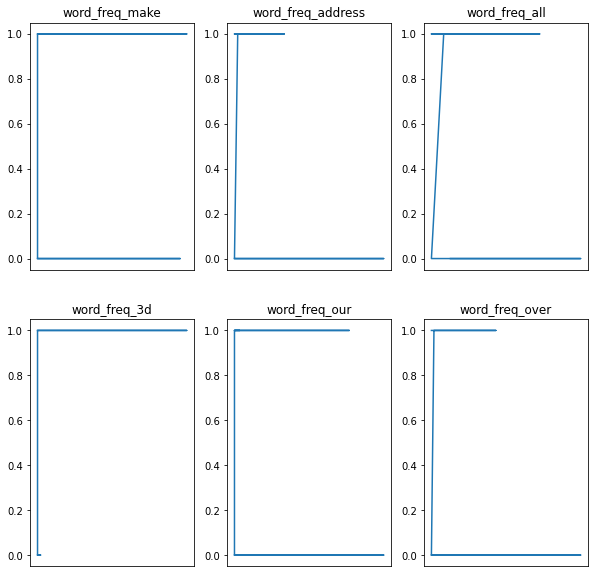

In [5]:
y = df.spam
fig, axs = plt.subplots(2, 3,figsize=(10,10))

axs[0, 0].plot(df.word_freq_make , y)
axs[0, 0].set_title('word_freq_make')
axs[0, 0].get_xaxis().set_visible(False)
axs[0, 1].plot(df.word_freq_address, y)
axs[0, 1].set_title('word_freq_address')
axs[0, 1].get_xaxis().set_visible(False)
axs[0, 2].plot(df.word_freq_all, y)
axs[0, 2].set_title('word_freq_all')
axs[0, 2].get_xaxis().set_visible(False)
axs[1, 0].plot(df.word_freq_3d, y)
axs[1, 0].set_title('word_freq_3d')
axs[1, 0].get_xaxis().set_visible(False)
axs[1, 1].plot(df.word_freq_our, y)
axs[1, 1].set_title('word_freq_our')
axs[1, 1].get_xaxis().set_visible(False)
axs[1, 2].plot(df.word_freq_over, y)
axs[1, 2].set_title('word_freq_over')
axs[1, 2].get_xaxis().set_visible(False)

Après avoir affiché les premières variables on s'est rendu compte que ces graphiques ne sont pas du tout exploitables, donc nous avons changé de stratégie. Le but de cette nouvelle stratégie est de comparer les attributs entre les mails de spam et les mails normaux.

In [6]:
df_spam = df.iloc[:1813,:]
df_nonspam = df.iloc[1813:,:]

In [7]:
def average(columns) :
  list_=columns.to_list()
  average = 0
  for i in range(len(list_)):
    average += float(list_[i])
  average = average/len(list_)
  return (average)

Création d'un nouveau dataframe contenant les moyennes des attributs des spam et les moyennes des attributs des non spam

In [8]:
df_average = pd.DataFrame()

list_attribute = ["word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail","word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses","word_freq_free","word_freq_business","word_freq_email","word_freq_you","word_freq_credit","word_freq_your","word_freq_font","word_freq_000","word_freq_money","word_freq_hp","word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs","word_freq_telnet","word_freq_857","word_freq_data","word_freq_415","word_freq_85","word_freq_technology","word_freq_1999","word_freq_parts","word_freq_pm","word_freq_direct","word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re","word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(","char_freq_[","char_freq_!","char_freq_$","char_freq_#","capital_run_length_average","capital_run_length_longest","capital_run_length_total"]
average_spam = []
average_nonspam =[]

for i in range (len(list_attribute)):
  avgs = average(df_spam.iloc[:,i])
  avgns = average(df_nonspam.iloc[:,i])
  average_spam.append(avgs)
  average_nonspam.append(avgns)

df_average['attribute'] =list_attribute 
df_average['average_spam'] = average_spam
df_average['average_nonspam'] = average_nonspam

df_average

,attribute,average_spam,average_nonspam
0,word_freq_make,0.152339,0.073479
1,word_freq_address,0.164650,0.244466
2,word_freq_all,0.403795,0.200581
3,word_freq_3d,0.164672,0.000886
4,word_freq_our,0.513955,0.181040
5,word_freq_over,0.174876,0.044544
6,word_freq_remove,0.275405,0.009383
7,word_freq_internet,0.208141,0.038415
8,word_freq_order,0.170061,0.038049
9,word_freq_mail,0.350507,0.167170


Avec ce nouveau dataframe on remarque que la plupart des attributs ont une grosse différence si ils sont dans un spam ou non 

On va maintenant essayer d'identifier quels attributs sont les plus impactants dans la détection de spam, pour cela nous avons commencé par faire un histogramme des valeurs des variables des mail de spam et de non spam, pour ainsi les comparer

In [9]:
df_average2 = df_average.iloc[:54,:]

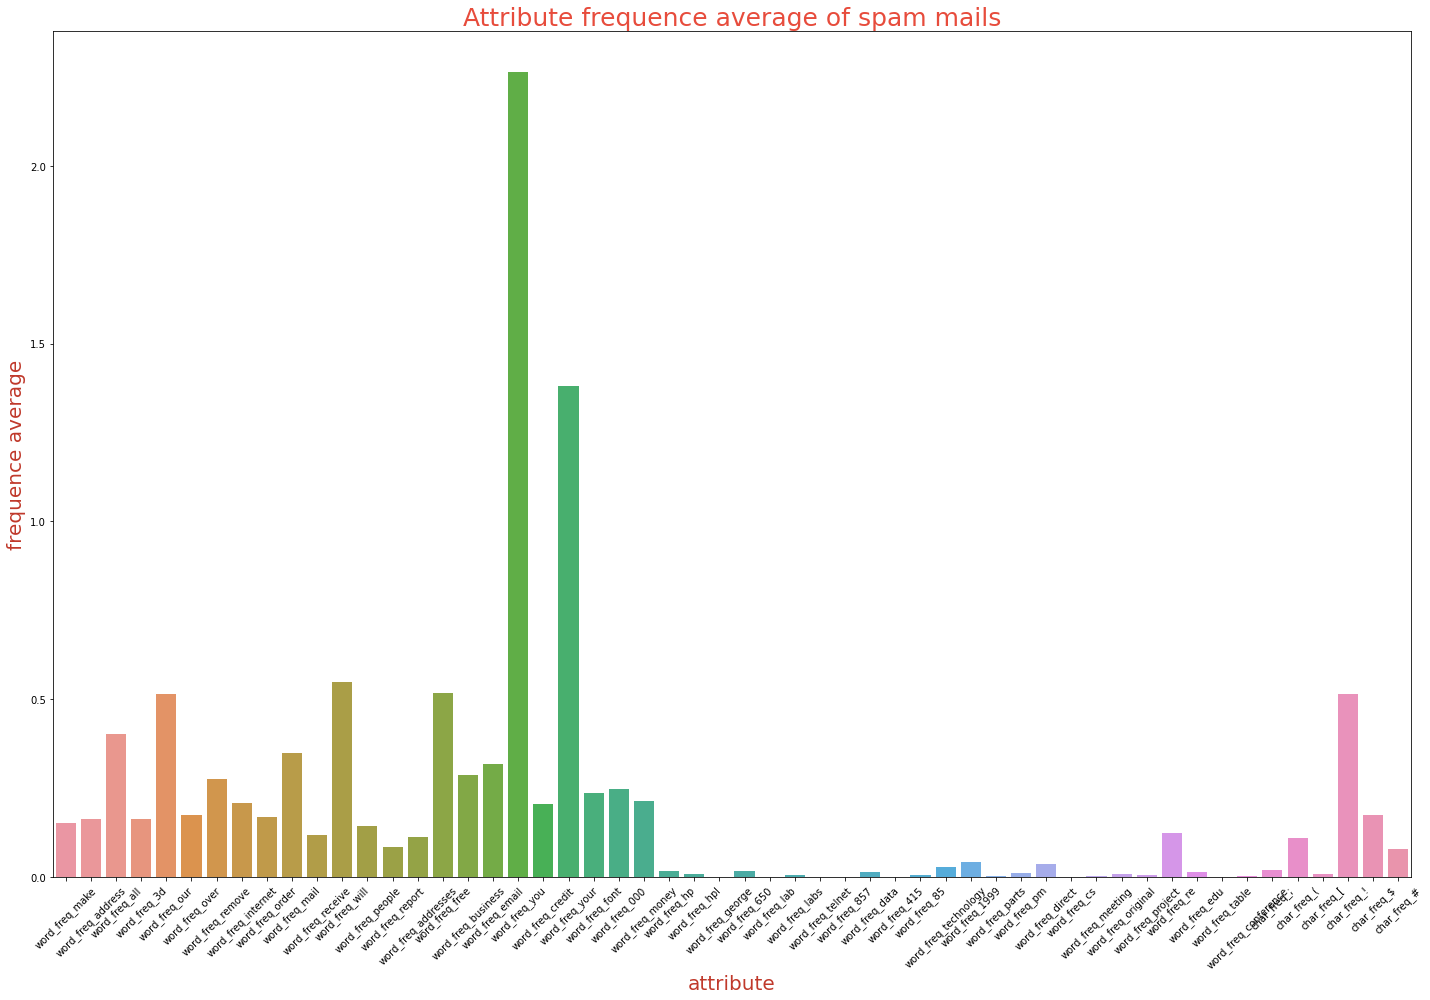

In [10]:
plt.figure(figsize=(20,14))
sns.barplot(x=df_average2['attribute'], y=df_average2['average_spam'])
plt.xlabel('attribute', fontsize=20, color='#c0392b')
plt.ylabel("frequence average", fontsize=20, color='#c0392b')
plt.title("Attribute frequence average of spam mails", fontsize=25, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

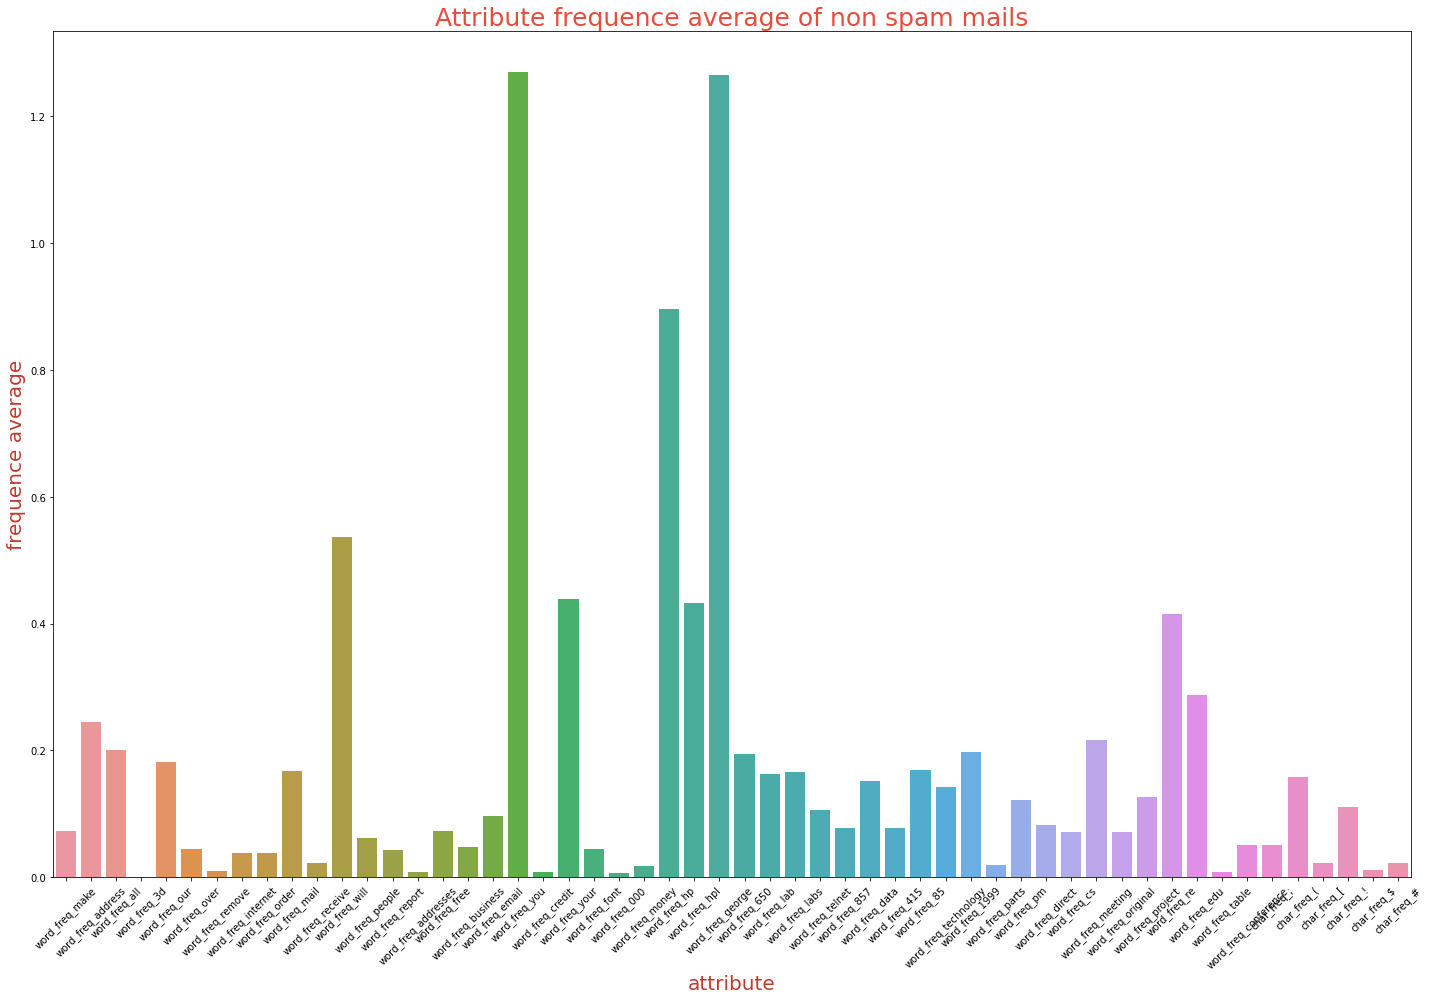

In [11]:
plt.figure(figsize=(20,14))
sns.barplot(x=df_average2['attribute'], y=df_average2['average_nonspam'])
plt.xlabel('attribute', fontsize=20, color='#c0392b')
plt.ylabel("frequence average", fontsize=20, color='#c0392b')
plt.title("Attribute frequence average of non spam mails", fontsize=25, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

Pour avoir une visualisation difféerente nous avons rajouté une colonne dans le dataframe des moyenne, cette colonne contientt la difference en pourcent entre la moyenne des variables en spam et celle des variables en non spam

In [12]:
pourcentage_dif = []
for i in range(57):
  dif = df_average.iloc[i,1]-df_average.iloc[i,2]
  dif = dif / df_average.iloc[i,2]
  dif = dif * 100
  pourcentage_dif.append(dif)

df_average['pourcentage_dif'] = pourcentage_dif
df_average

,attribute,average_spam,average_nonspam,pourcentage_dif
0,word_freq_make,0.152339,0.073479,107.322171
1,word_freq_address,0.164650,0.244466,-32.649103
2,word_freq_all,0.403795,0.200581,101.312533
3,word_freq_3d,0.164672,0.000886,18487.247745
4,word_freq_our,0.513955,0.181040,183.889904
5,word_freq_over,0.174876,0.044544,292.587164
6,word_freq_remove,0.275405,0.009383,2835.131003
7,word_freq_internet,0.208141,0.038415,441.827892
8,word_freq_order,0.170061,0.038049,346.954333
9,word_freq_mail,0.350507,0.167170,109.671243


Nous avons laissé les négatifs car ils rendent la lecture plus simple pour savoir si la variable est plutot pro-spam ou anti-spam.

Pour completer la visualistaion nous avons rajouter une colonne au dataframe indicant si la variables est pro-spam, anti-spam ou neutre.
Nous avons considérer que les différences inférieurs à 50% n'etaient pas assez marquées pour être directement marquées comme pro-spam ou anti-spam

In [13]:
favorability = []
for i in range(57):
  fav = None
  if (df_average.iloc[i,3] > 50):
    fav = "pro-spam"
  elif (df_average.iloc[i,3] < -50):
    fav = "anti-spam"
  else :
    fav = "neutre"
  favorability.append(fav)



df_average['favorability'] = favorability
df_average

,attribute,average_spam,average_nonspam,pourcentage_dif,favorability
0,word_freq_make,0.152339,0.073479,107.322171,pro-spam
1,word_freq_address,0.164650,0.244466,-32.649103,neutre
2,word_freq_all,0.403795,0.200581,101.312533,pro-spam
3,word_freq_3d,0.164672,0.000886,18487.247745,pro-spam
4,word_freq_our,0.513955,0.181040,183.889904,pro-spam
5,word_freq_over,0.174876,0.044544,292.587164,pro-spam
6,word_freq_remove,0.275405,0.009383,2835.131003,pro-spam
7,word_freq_internet,0.208141,0.038415,441.827892,pro-spam
8,word_freq_order,0.170061,0.038049,346.954333,pro-spam
9,word_freq_mail,0.350507,0.167170,109.671243,pro-spam


# Preparation des données


In [14]:
#df.sort_values(by=['col1'])
df=shuffle(df)
dfTrain = df[:3801]
dfTest = df[3801:]
#dfTrain.sort_index()
#dfTest.sort_index()

X_Train=dfTrain.loc[:,df.columns != 'spam']
Y_Train=dfTrain.loc[:,'spam']
X_Test=dfTest.loc[:,df.columns != 'spam']
Y_Test=dfTest.loc[:,'spam']


In [15]:
def grid_search(X, Y, model, param_grid={}):
    rk = {'random_state':42}
    try:
        model(**rk)
    except:
        rk = {}
        
    grid = GridSearchCV(
        model(**rk),
        param_grid=param_grid,
        cv=ShuffleSplit(n_splits=4, random_state=20),
        verbose=0,
        n_jobs=-1
    )

    grid.fit(X, Y)
    return grid

# modèles de machine learning

Pour chacun des modèles nous faisons un gridsearch dont le but de tester le modele avec plusieurs parametres. 

Ensuite nous affichons et classons les parametres pour ne selectionner que les meilleurs.

Nous reproduisons ensuite le meilleur modele afin de l'enregistrer. 
Nous affichons à ce moment le taux de réussite du modele.

Le meilleur modele est enfin sélectionné pour notre API. Dans notre cas il s'agit du random Forest.

La regression linéaire est le seul modele qui n'a pas de grids search, il n'y  pas de paramettre important à tester


## Regression Lineaire

Algorithme des moindres carrés ordinaires

In [16]:
modelLineaire = LinearRegression()


modelLineaire.fit(X_Train, Y_Train)
Y_Prediction=modelLineaire.predict(X_Test)

Y_PredictionBinarie=[]
for i in range(len(Y_Prediction)):
    if Y_Prediction[i]>0.5:
        Y_PredictionBinarie.append(1)
    else:
       Y_PredictionBinarie.append(0)

counter=0
iterator=0
for i, value in Y_Test.iteritems():

    if(int(Y_PredictionBinarie[iterator])==int(value)):
       counter=counter+1
    iterator=iterator+1


# The coefficients
print('Coefficients: \n', modelLineaire.coef_)
# The mean squared error
print('Moyenne des écarts au carré: %.2f'
      % mean_squared_error(Y_Test, Y_Prediction))


print("Taux de bons resultats: ",counter/8,'%')


Coefficients: 
 [-5.01424510e-02 -1.16116882e-02  3.57171060e-02  1.18396112e-02
  8.86157523e-02  1.10301815e-01  2.00906605e-01  9.66269785e-02
  6.42105665e-02  9.23949005e-03  5.13308946e-02 -2.63665557e-02
 -9.85703416e-04 -8.38638234e-03  2.28125437e-02  6.97902417e-02
  4.81861685e-02  6.53601155e-02  1.42522639e-02  6.03416357e-02
  5.09215709e-02  4.30864275e-02  1.71944463e-01  9.35037807e-02
 -2.63940994e-02 -2.62132971e-02 -1.28009644e-02  9.22135122e-03
 -5.58080745e-03 -5.33829478e-02 -2.31813727e-02  3.98858492e-02
 -4.06421501e-02  2.08412131e-02 -2.80269512e-02  2.55690725e-02
 -2.53287914e-02 -5.32554100e-02 -1.18587479e-02  4.73872711e-02
 -6.22194544e-03 -3.52530378e-02 -6.73018583e-02 -3.93035086e-02
 -4.14352156e-02 -3.69435289e-02 -2.02706357e-01 -6.23267687e-02
 -1.44914771e-01 -9.25971369e-02 -5.11371293e-02  6.41612569e-02
  2.30813330e-01  2.84586858e-02  2.30825017e-04  7.86008945e-05
  9.03537737e-05]
Moyenne des écarts au carré: 0.10
Taux de bons resultats

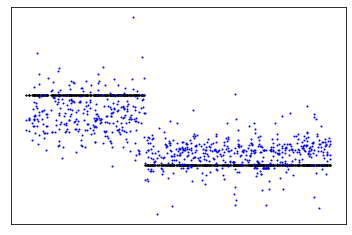

In [17]:
plt.scatter(X_Test.index, Y_Test,color='black', s=1)
plt.scatter(X_Test.index, Y_Prediction, color='blue', s=1)

plt.xticks(())
plt.yticks(())

plt.show()

## HuberRegressor

Un modèle linéaire conçu pour traiter les valeurs aberrantes dans les données et / ou les données corrompues. N'ignore pas les valeurs aberrantes, mais leur donne plutôt un poids inférieur.

In [18]:
modelHuber = HuberRegressor

param_grid = {
    'epsilon': [1, 1.2, 1.35, 1.5, 2, 3, 5, 10],
}
useful_columns = ['param_' + k for k in param_grid.keys()] + ['mean_test_score', 'std_test_score', 'rank_test_score']
grid = grid_search(X_Train, Y_Train, modelHuber, param_grid)
pd.DataFrame(grid.cv_results_)[useful_columns].sort_values('rank_test_score')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,param_epsilon,mean_test_score,std_test_score,rank_test_score
7,10,0.447169,0.115071,1
2,1.35,0.445210,0.079147,2
6,5,0.444887,0.111008,3
4,2,0.426502,0.111661,4
5,3,0.415119,0.103132,5
3,1.5,0.405845,0.125355,6
1,1.2,0.403720,0.108485,7
0,1,0.373350,0.072589,8


In [19]:
modelHuber = HuberRegressor(epsilon= 5).fit(X_Train,Y_Train)
Y_Prediction=modelHuber.predict(X_Test)

Y_PredictionBinarie=[]
for i in range(len(Y_Prediction)):
    if Y_Prediction[i]>0.5:
        Y_PredictionBinarie.append(1)
    else:
       Y_PredictionBinarie.append(0)

counter=0
iterator=0
for i, value in Y_Test.iteritems():

    if(int(Y_PredictionBinarie[iterator])==int(value)):
       counter=counter+1
    iterator=iterator+1

print("Taux de bons resultats: ",counter/8,'%')

Taux de bons resultats:  88.0 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


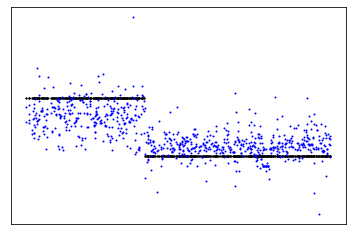

In [20]:
plt.scatter(X_Test.index, Y_Test,color='black', s=1)
plt.scatter(X_Test.index, Y_Prediction, color='blue', s=1)

plt.xticks(())
plt.yticks(())

plt.show()

## Random Forest Regressor

Le random Forest ajuste un certain nombre de classificateurs d'arbres de décision sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler le sur-ajustement.

Ces calcul peuvent etre très très long, je les ai fait,cela a pris environ 1h30. Voila la grille testé complete. Seul certain parametre incluant les plus performant ont été gardé. 

1.   max_depth': [None, 10,20, 50, 100]
2.   n_estimators': [10,50, 100, 200]
3.   criterion': ['mse','mae']
4.   'max_features' : ['auto','sqrt', 'log2']








In [21]:
modelRandomForest = RandomForestRegressor

param_grid = {
    'max_depth': [None, 10,20, 50, 100],
    'criterion': ['mse'],
    'n_estimators': [10,50,100],
    'max_features' : ['auto'] 
   
}
useful_columns = ['param_' + k for k in param_grid.keys()] + ['mean_test_score', 'std_test_score', 'rank_test_score']
grid = grid_search(X_Train, Y_Train, modelRandomForest, param_grid)
pd.DataFrame(grid.cv_results_)[useful_columns].sort_values('rank_test_score')

,param_max_depth,param_criterion,param_n_estimators,param_max_features,mean_test_score,std_test_score,rank_test_score
2,None,mse,100,auto,0.802498,0.048461,1
11,50,mse,100,auto,0.802498,0.048461,1
14,100,mse,100,auto,0.802498,0.048461,1
1,None,mse,50,auto,0.799061,0.049504,4
10,50,mse,50,auto,0.799061,0.049504,4
13,100,mse,50,auto,0.799061,0.049504,4
8,20,mse,100,auto,0.796670,0.052175,7
7,20,mse,50,auto,0.795773,0.054096,8
0,None,mse,10,auto,0.780784,0.050189,9
9,50,mse,10,auto,0.780784,0.050189,9


In [22]:
modelRandomForest = RandomForestRegressor(max_depth=None ,criterion='mse',n_estimators=100,max_features='auto').fit(X_Train,Y_Train)
Y_Prediction=modelRandomForest.predict(X_Test)

Y_PredictionBinarie=[]
for i in range(len(Y_Prediction)):
    if Y_Prediction[i]>0.5:
        Y_PredictionBinarie.append(1)
    else:
       Y_PredictionBinarie.append(0)

counter=0
iterator=0
for i, value in Y_Test.iteritems():

    if(int(Y_PredictionBinarie[iterator])==int(value)):
       counter=counter+1
    iterator=iterator+1

print("Taux de bons resultats: ",counter/8,'%')

Taux de bons resultats:  94.875 %


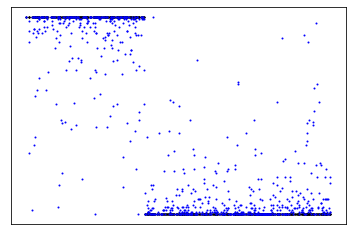

In [23]:
plt.scatter(X_Test.index, Y_Test,color='black', s=1)
plt.scatter(X_Test.index, Y_Prediction, color='blue', s=1)

plt.xticks(())
plt.yticks(())

plt.show()

## K Nearest Neighbors regressor

Régression basée sur les k voisins les plus proches.

La cible est prédite par interpolation locale des cibles associées des voisins les plus proches dans l'ensemble des données.

In [24]:
modelKNeighbors = KNeighborsRegressor
param_grid = {
    'n_neighbors': [1,3, 5, 10, 15, 20,50,100,300],  
    'p': [0.5, 1, 2],
    'algorithm': ['ball_tree', 'kd_tree'],
    'weights': ['uniform', 'distance']
}
useful_columns = ['param_' + k for k in param_grid.keys()] + [ 'mean_test_score', 'std_test_score', 'rank_test_score']

grid = grid_search(X_Train, Y_Train, modelKNeighbors, param_grid)
pd.DataFrame(grid.cv_results_)[useful_columns].sort_values('rank_test_score')

,param_n_neighbors,param_p,param_algorithm,param_weights,mean_test_score,std_test_score,rank_test_score
21,10,1,ball_tree,distance,0.579765,0.016382,1
75,10,1,kd_tree,distance,0.579481,0.016734,2
81,15,1,kd_tree,distance,0.574007,0.020231,3
27,15,1,ball_tree,distance,0.573950,0.020241,4
33,20,1,ball_tree,distance,0.564843,0.023643,5
...,...,...,...,...,...,...,...
79,15,0.5,kd_tree,distance,NaN,NaN,104
24,15,0.5,ball_tree,uniform,NaN,NaN,105
19,10,0.5,ball_tree,distance,NaN,NaN,106
36,50,0.5,ball_tree,uniform,NaN,NaN,107


In [25]:
modelKNeighbors = KNeighborsRegressor(n_neighbors=10,weights='distance',algorithm='kd_tree',p=1).fit(X_Train,Y_Train)
Y_Prediction=modelKNeighbors.predict(X_Test)

Y_PredictionBinarie=[]
for i in range(len(Y_Prediction)):
    if Y_Prediction[i]>0.5:
        Y_PredictionBinarie.append(1)
    else:
       Y_PredictionBinarie.append(0)

counter=0
iterator=0
for i, value in Y_Test.iteritems():

    if(int(Y_PredictionBinarie[iterator])==int(value)):
       counter=counter+1
    iterator=iterator+1

print("Taux de bons resultats: ", counter/8,'%')

Taux de bons resultats:  84.0 %


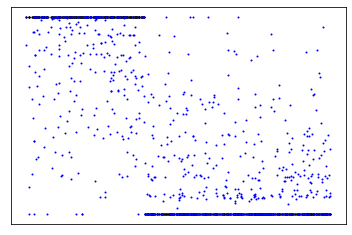

In [26]:
plt.scatter(X_Test.index, Y_Test,color='black', s=1)
plt.scatter(X_Test.index, Y_Prediction, color='blue', s=1)

plt.xticks(())
plt.yticks(())

plt.show()

## Model ElasticNet

Moindres carrés ordinaires avec un terme de régularisation L1 et L2. Les poids des termes de régularisation L1 vs L2 sont contrôlés

In [27]:
modelElasticNet = ElasticNet


param_grid = {
    'alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
    'l1_ratio': [0, 0.2, 0.5, 0.8, 1], 
    'max_iter': [20000]
}
useful_columns = ['param_' + k for k in param_grid.keys()] + ['mean_test_score', 'std_test_score', 'rank_test_score']

grid = grid_search(X_Train, Y_Train, modelElasticNet, param_grid)
pd.DataFrame(grid.cv_results_)[useful_columns].sort_values('rank_test_score')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.77872817455238, tolerance: 0.09086803472770347
  positive)


,param_alpha,param_l1_ratio,param_max_iter,mean_test_score,std_test_score,rank_test_score
0,0.01,0,20000,0.491664,0.097705,1
1,0.01,0.2,20000,0.490344,0.093515,2
5,0.1,0,20000,0.488812,0.077999,3
2,0.01,0.5,20000,0.480362,0.087173,4
10,0.25,0,20000,0.472566,0.058415,5
3,0.01,0.8,20000,0.471533,0.082303,6
4,0.01,1,20000,0.464319,0.079785,7
15,0.5,0,20000,0.447315,0.043608,8
20,0.75,0,20000,0.425886,0.037082,9
25,0.9,0,20000,0.414582,0.034739,10


In [28]:
modelElasticNet = ElasticNet(alpha=0.01,l1_ratio=0,max_iter=20000).fit(X_Train,Y_Train)
Y_Prediction=modelElasticNet.predict(X_Test)

Y_PredictionBinarie=[]
for i in range(len(Y_Prediction)):
    if Y_Prediction[i]>0.5:
        Y_PredictionBinarie.append(1)
    else:
       Y_PredictionBinarie.append(0)

counter=0
iterator=0
for i, value in Y_Test.iteritems():

    if(int(Y_PredictionBinarie[iterator])==int(value)):
       counter=counter+1
    iterator=iterator+1

print("Taux de bons resultats: ", counter/8,'%')

Taux de bons resultats:  89.25 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.77872817455238, tolerance: 0.09086803472770347
  positive)


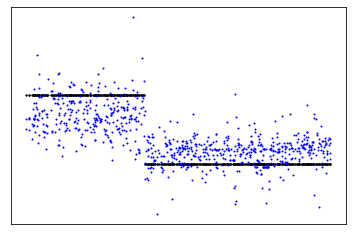

In [29]:
plt.scatter(X_Test.index, Y_Test,color='black', s=1)
plt.scatter(X_Test.index, Y_Prediction, color='blue', s=1)

plt.xticks(())
plt.yticks(())

plt.show()

# API

In [30]:
filename = "model.pkl"
with open(filename, 'wb') as f:
    joblib.dump(modelRandomForest, f)

In [31]:
model_columns = list(df.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")

Models columns dumped!


In [ ]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    json_ = request.json
    print(json_)
    query = pd.get_dummies(pd.DataFrame(json_))
    query = query.reindex(columns=model_columns, fill_value=0)

    for i in range(len(prediction)):
       if prediction[i]>0.5:
            prediction[i]=True
       else:
            prediction[i]=False
       print('prediction: is the message a spam?', str(prediction[i]))

    return jsonify({'prediction: Are/is this/these message(s) (a) spam(s)?': str(prediction)})

if __name__ == '__main__':
    lr = joblib.load(open('model.pkl','rb'))
    print ('Model loaded')
    model_columns = joblib.load("model_columns.pkl")
    print ('Model columns loaded')

    app.run(port=5000, debug=True)

Nous faisons tournée notre API en local.
Pou cela il nous suffit d'executer le model.py
Nous utilisons 3 variable test enregistrer dans le fichier test.json.

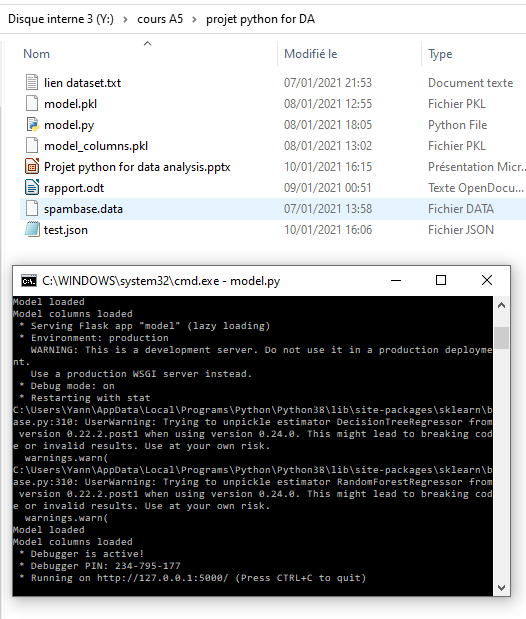

Nous avons donc testés notre API avec Postman, un logiciel permettant de faire des requetes post ou get entre autres, et donc de tester notre API.
Voici un visuel des résultats de notre API sur Postman

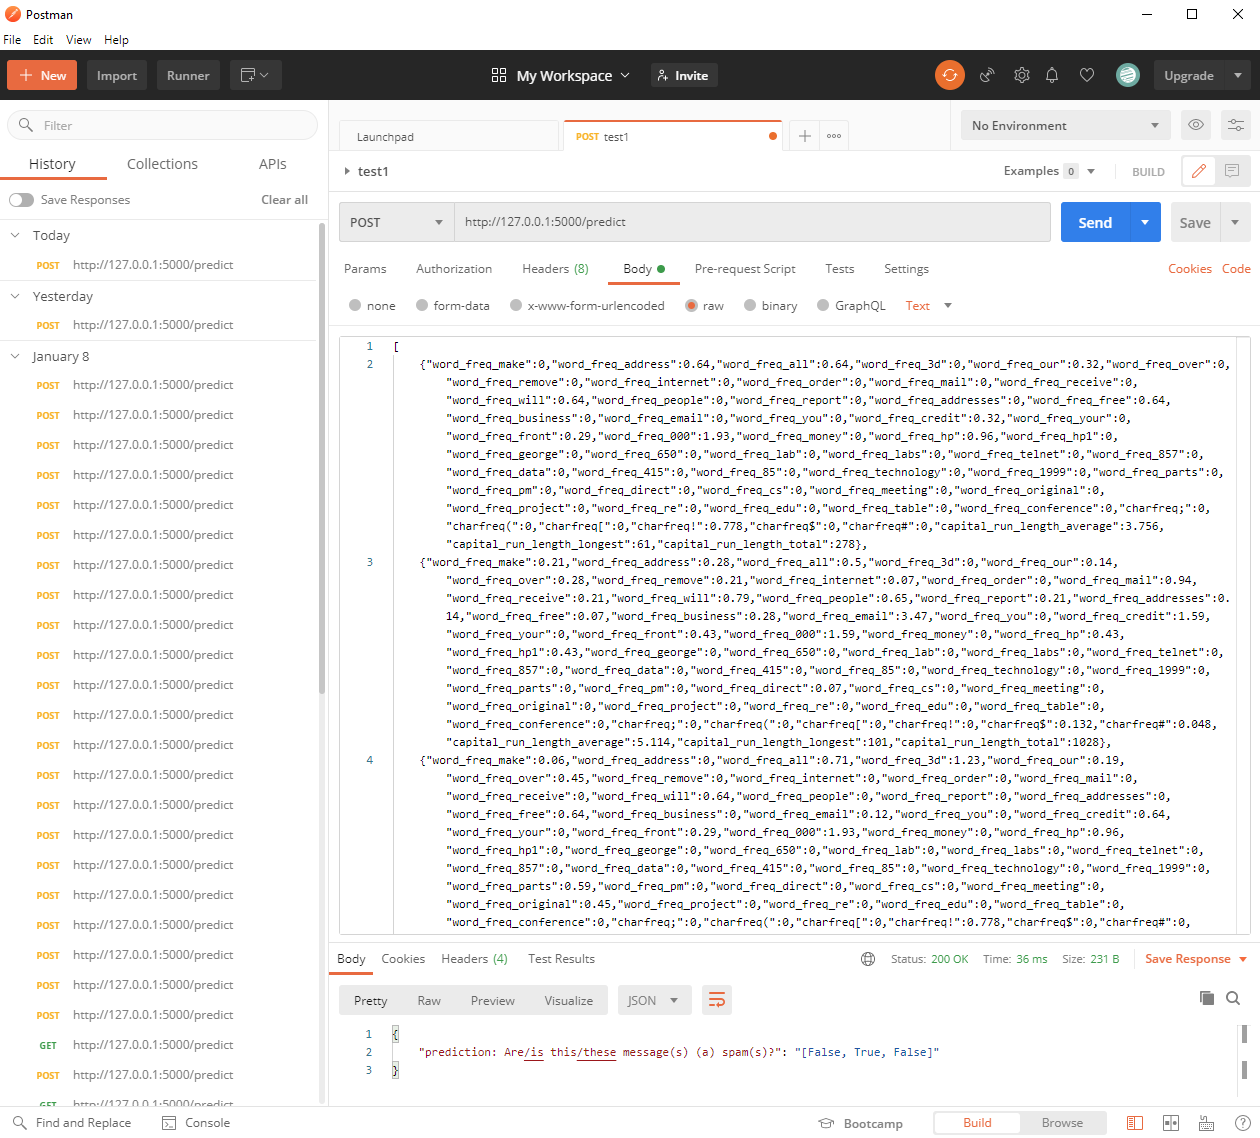

Voici un visuel du resultat sur la console.
J'ai choisis d'y afficher la requete reçu ainsi que les resultats renvoyé. 

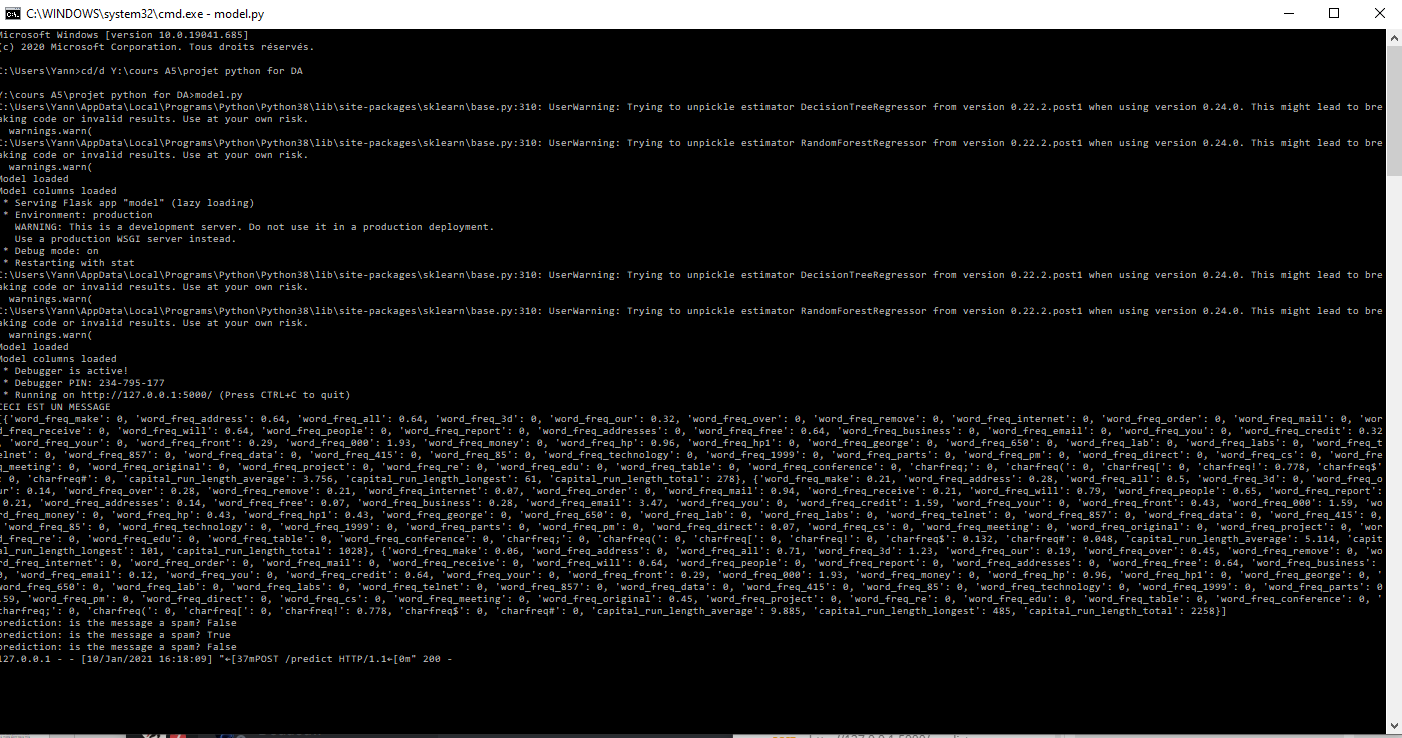